# AdventureWorks Försäljninganalys
I denna analys undersöka vi AdventureWorks-databasen för att besvara affärsfrågor som examplevis:
- produktkategrier och deras föräsljning
- Försälninhtrender över tid 
- Regional försäljning

Vi använder SQL för att hämta data och python för visualisering och analys.

In [4]:
import pandas as pd 
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "sa"
password = quote_plus("StrongPassw0rd!")
server = 'localhost,1433'
database = "AdventureWorks2022"
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


In [5]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Visualisering 1: Antal produkt per Kategori 
Hur många produkter finns i varje kategori?

Table som används:
Production.Productcategory
Production.Productsubcategory
Production.product

Plan:
JOIN tabellerna 
Räkna DISTINCT produkter per kategori
Skapa vertikalt stepeldiagram
Analysera resultatet


<function matplotlib.pyplot.show(close=None, block=None)>

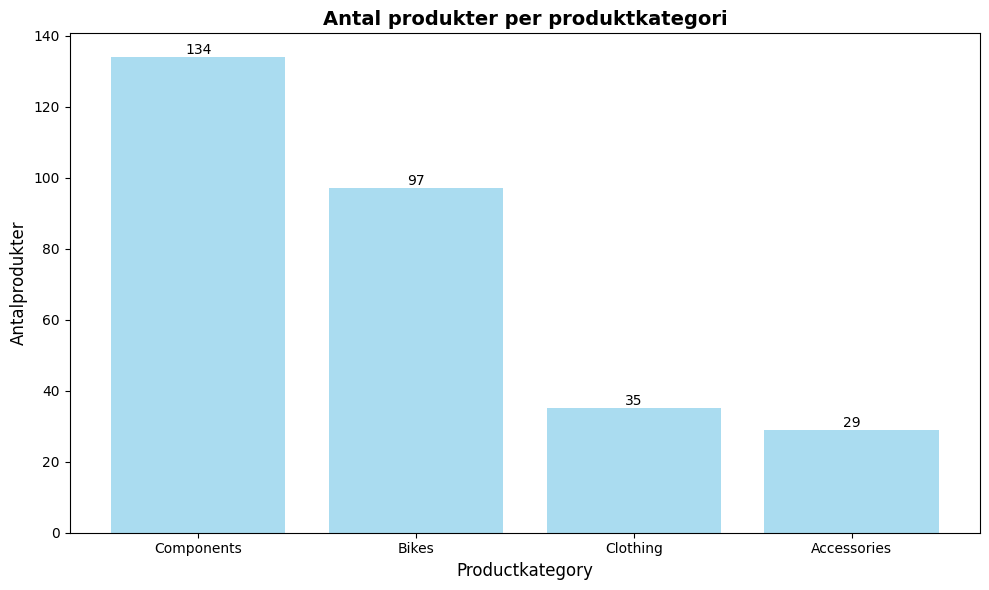

In [4]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT(DISTINCT p.ProductID) AS ProductCount

FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)



fig, ax = plt.subplots(figsize=(10, 6))  

bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color='skyblue' , alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text( 
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha = 'center',
        va= 'bottom'
    )

    
ax.set_xlabel('Productkategory' , fontsize=12) 
ax.set_ylabel('Antalprodukter' , fontsize=12)
ax.set_title('Antal produkter per produktkategori', fontsize=14, fontweight='bold')


plt.tight_layout()
plt.show



### Insikter produkter per kategori 
Components är största kategori med 134 produkter
Accessoires minst med 29 produkter.

Detta indikerar på att företaget är starkt fokuserat på componenter och reserdelar. Och att accessories kan vara ett utvecklingsområde.

## Visualisering 2 – Total försäljning per produktkategori
Affärsfråga: Vilka produktkategorier säljer mest?
Tabeller som används:

- Production.ProductCategory

- Production.ProductSubcategory

- Production.Product

- Sales.SalesOrderDetail

Plan:

- JOIN kategorier → subkategorier → produkter → orderrader

- Beräkna total försäljning (LineTotal)

- Sortera från högst till lägst

- Skapa horisontellt stapeldiagram

- Analysera resultatet


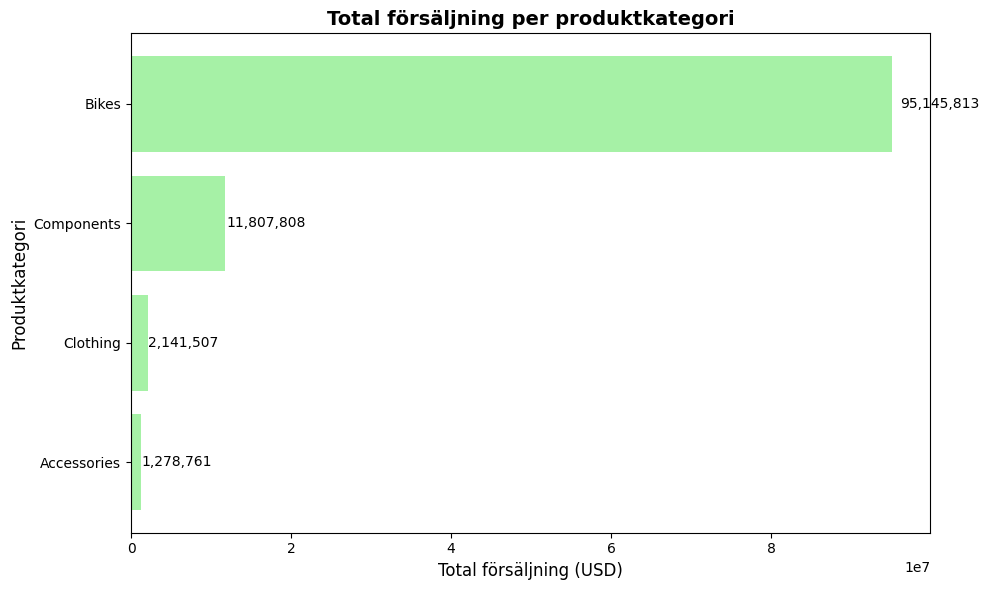

In [10]:
# SQL-query för visualisering 2
query_vis2 = """
SELECT 
    pc.Name AS CategoryName,
    SUM(sod.OrderQty * sod.UnitPrice) AS TotalSales
FROM Production.ProductCategory pc
INNER JOIN Production.ProductSubcategory psc 
    ON pc.ProductCategoryID = psc.ProductCategoryID
INNER JOIN Production.Product p 
    ON psc.ProductSubcategoryID = p.ProductSubcategoryID
INNER JOIN Sales.SalesOrderDetail sod 
    ON p.ProductID = sod.ProductID
GROUP BY pc.Name
ORDER BY TotalSales DESC;
"""

df_vis2 = query_df(query_vis2)

# Visualisering
fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(df_vis2['CategoryName'], df_vis2['TotalSales'], color='lightgreen', alpha=0.8)
ax.invert_yaxis()  # högsta värdet överst

# Etiketter på staplarna
for i, v in enumerate(df_vis2['TotalSales']):
    ax.text(v + (v * 0.01), i, f"{v:,.0f}", va='center')

ax.set_xlabel("Total försäljning (USD)", fontsize=12)
ax.set_ylabel("Produktkategori", fontsize=12)
ax.set_title("Total försäljning per produktkategori", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


## Insikter – Försäljning per produktkategori

Bikes är den kategori som genererar mest intäkter, med en total försäljning på cirka 95 miljoner USD.  
Accessories är den kategori som genererar minst intäkter, med cirka 1,3 miljoner USD.

Trots att Components har många produkter (enligt visualisering 1), står Bikes för den klart största delen av intäkterna.  
Detta visar att företaget tjänar mest pengar på ett mindre antal dyrare produkter, främst cyklar.


## Visualisering 3 – Försäljningstrend per månad
Affärsfråga: Hur utvecklas försäljningen över tid?
Tabell som används:

- Sales.SalesOrderHeader

Plan:

- Hämta total försäljning per månad

- Använd YEAR + MONTH för bättre prestanda

- Sortera månader i kronologisk ordning

- Skapa linjediagram

- Analysera trenden


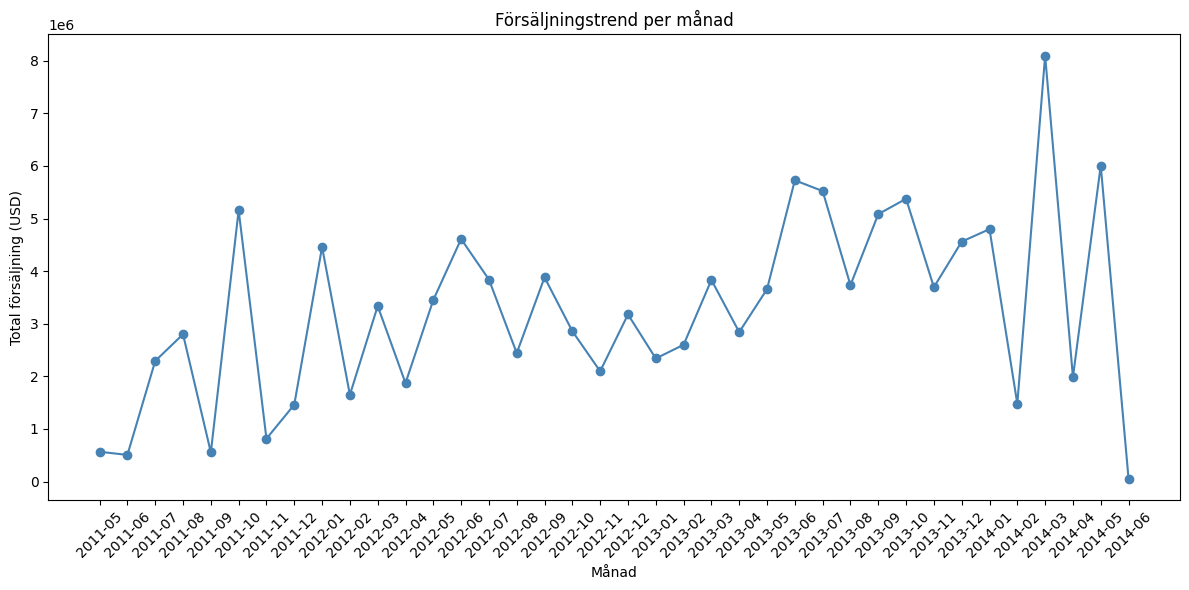

In [14]:
# Optimerad SQL-query för visualisering 3
query_vis3 = """
SELECT
    YEAR(OrderDate) AS Year,
    MONTH(OrderDate) AS Month,
    SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate), MONTH(OrderDate)
ORDER BY YEAR(OrderDate), MONTH(OrderDate);
"""

df_vis3 = query_df(query_vis3)

# Skapa YearMonth-kolumn i Python
df_vis3['YearMonth'] = df_vis3['Year'].astype(str) + "-" + df_vis3['Month'].astype(str).str.zfill(2)

# Visualisering
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_vis3['YearMonth'], df_vis3['TotalSales'], marker='o', color='steelblue')

ax.set_xlabel("Månad")
ax.set_ylabel("Total försäljning (USD)")
ax.set_title("Försäljningstrend per månad")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Insikter – Försäljningstrend över tid

Försäljningen varierar tydligt mellan månaderna och visar en övergripande ökande trend över tid.  
Det finns ett tydligt säsongsmönster med högre försäljning under sommaren och mot slutet av året.

Den högsta försäljningen sker i mars 2014, med cirka 8,1 miljoner USD.  
Den lägsta försäljningen sker i juni 2014, med cirka 0,1 miljoner USD.
(Den mycket låga försäljningen i juni 2014 kan bero på att månaden inte innehåller fullständiga data.)

Resultatet tyder på att försäljningen är säsongsberoende, vilket kan användas för bättre planering av lager och marknadsföring.


## Visualisering 4 – Försäljning och antal ordrar per år
Affärsfråga: Hur ser total försäljning och antal ordrar ut per år?
Tabell som används:

- Sales.SalesOrderHeader

Plan:

- Räkna total försäljning per år

- Räkna antal ordrar per år

- Skapa två separata stapeldiagram

- Jämför år mot år

- Analysera skillnader


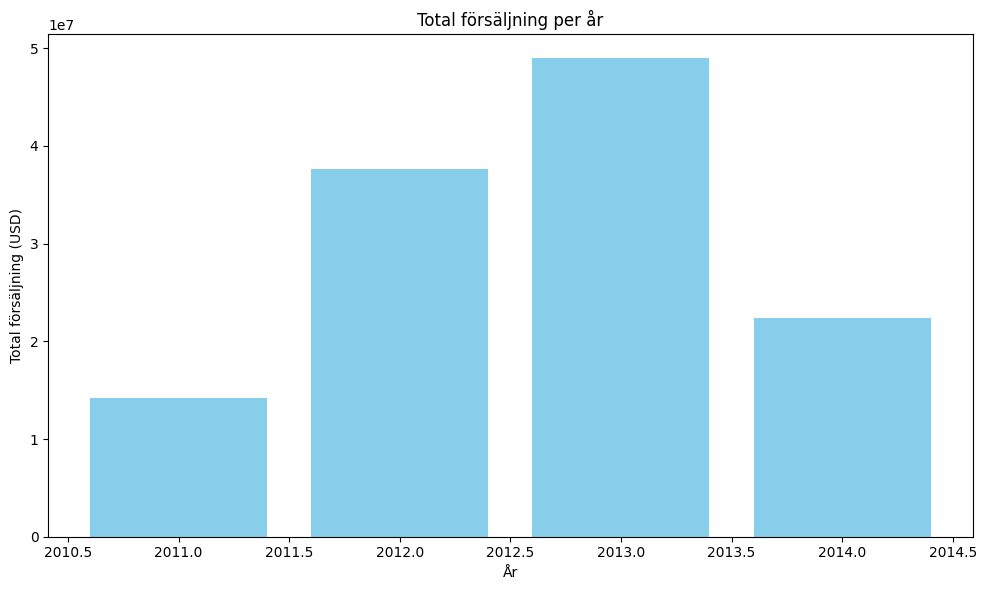

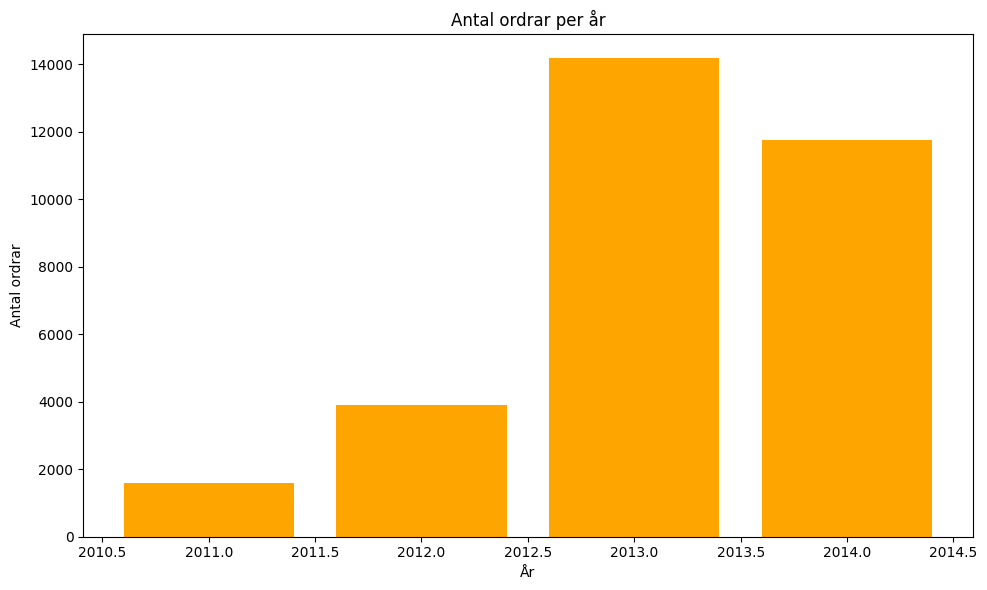

In [6]:
# SQL-query för visualisering 4
query_vis4 = """
SELECT
    YEAR(OrderDate) AS Year,
    SUM(TotalDue) AS TotalSales,
    COUNT(SalesOrderID) AS OrderCount
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY YEAR(OrderDate);
"""

df_vis4 = query_df(query_vis4)

# -----------------------------
# Diagram 1: Total försäljning per år
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(df_vis4['Year'], df_vis4['TotalSales'], color='skyblue')

ax.set_xlabel("År")
ax.set_ylabel("Total försäljning (USD)")
ax.set_title("Total försäljning per år")

plt.tight_layout()
plt.show()

# -----------------------------
# Diagram 2: Antal ordrar per år
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(df_vis4['Year'], df_vis4['OrderCount'], color='orange')

ax.set_xlabel("År")
ax.set_ylabel("Antal ordrar")
ax.set_title("Antal ordrar per år")

plt.tight_layout()
plt.show()


### Insikter – Försäljning och antal ordrar per år

Total försäljning ökar från 2011 till 2013 och når sin topp 2013.  
År 2014 minskar försäljningen igen, vilket tyder på en nedgång i efterfrågan eller förändringar i marknaden.

Antalet ordrar följer samma mönster: en stadig ökning fram till 2013, följt av en minskning 2014.  
Det visar att tillväxten under perioden kom både från fler ordrar och högre ordervärden.

Företaget hade sin starkaste period 2013, både i volym och intäkt.  
Det kan vara värdefullt att analysera vad som drev framgången det året och om dessa faktorer kan återskapas.



## Visualisering 5: Top 10 produkter
Vilka produkter genererar mest försäljning?

Tabeller som används:

- Production.Product

- Sales.SalesOrderDetail

Plan:

- JOIN produkter och orderrader

- Beräkna total försäljning per produkt

- Sortera från högst till lägst

- Välj TOP 10

- Skapa horisontellt stapeldiagram

- Analysera resultatet

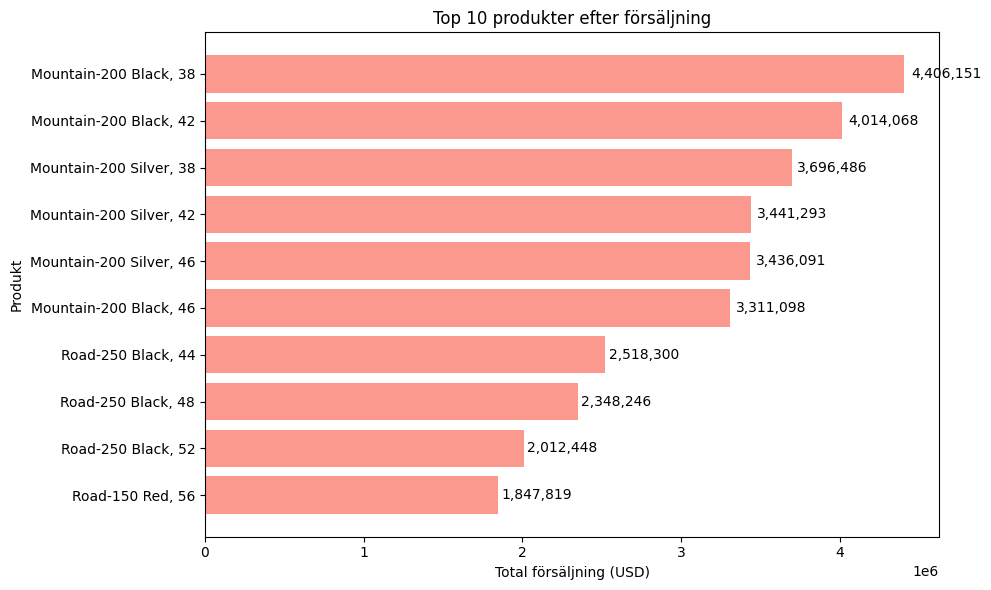

In [18]:
# SQL-query för visualisering 5
query_vis5 = """
SELECT TOP 10
    p.Name AS ProductName,
    SUM(sod.OrderQty * sod.UnitPrice) AS TotalSales
FROM Production.Product p
INNER JOIN Sales.SalesOrderDetail sod
    ON p.ProductID = sod.ProductID
GROUP BY p.Name
ORDER BY TotalSales DESC;
"""

df_vis5 = query_df(query_vis5)

# Visualisering
fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(df_vis5['ProductName'], df_vis5['TotalSales'], color='salmon', alpha=0.8)
ax.invert_yaxis()  # högsta överst

# Etiketter på staplarna
for i, v in enumerate(df_vis5['TotalSales']):
    ax.text(v + (v * 0.01), i, f"{v:,.0f}", va='center')

ax.set_xlabel("Total försäljning (USD)")
ax.set_ylabel("Produkt")
ax.set_title("Top 10 produkter efter försäljning")

plt.tight_layout()
plt.show()


### Insikter – Top 10 produkter

Den produkt som genererar mest försäljning är **Mountain-200 Black, 38**, med **4,406,151 USD** i total försäljning.

Alla produkter i topp 10 tillhör cykelmodeller som Mountain-200 och Road-250.  
Det betyder att **Bikes-kategorin dominerar listan**, vilket stämmer med tidigare visualiseringar.

Produkterna i toppen är dyrare premiumcyklar, vilket driver upp total försäljning.  
Företagets intäkter är starkt beroende av ett fåtal högvärdesprodukter.

Det är viktigt att säkra lager, tillgänglighet och marknadsföring för dessa produkter.


## Visualisering 6: Försäljning och antal kunder per region
Hur skiljer sig försäljningen mellan regioner, och hur många kunder finns i varje region?

Tabeller som används
- Sales.SalesTerritory  
- Sales.SalesOrderHeader  
- Sales.Customer  

Plan
- JOIN territorier, ordrar och kunder  
- Räkna total försäljning per region  
- Räkna antal unika kunder per region  
- Sortera regioner från högst till lägst försäljning  
- Skapa två separata stapeldiagram: ett för försäljning och ett för antal kunder  
- Analysera resultatet

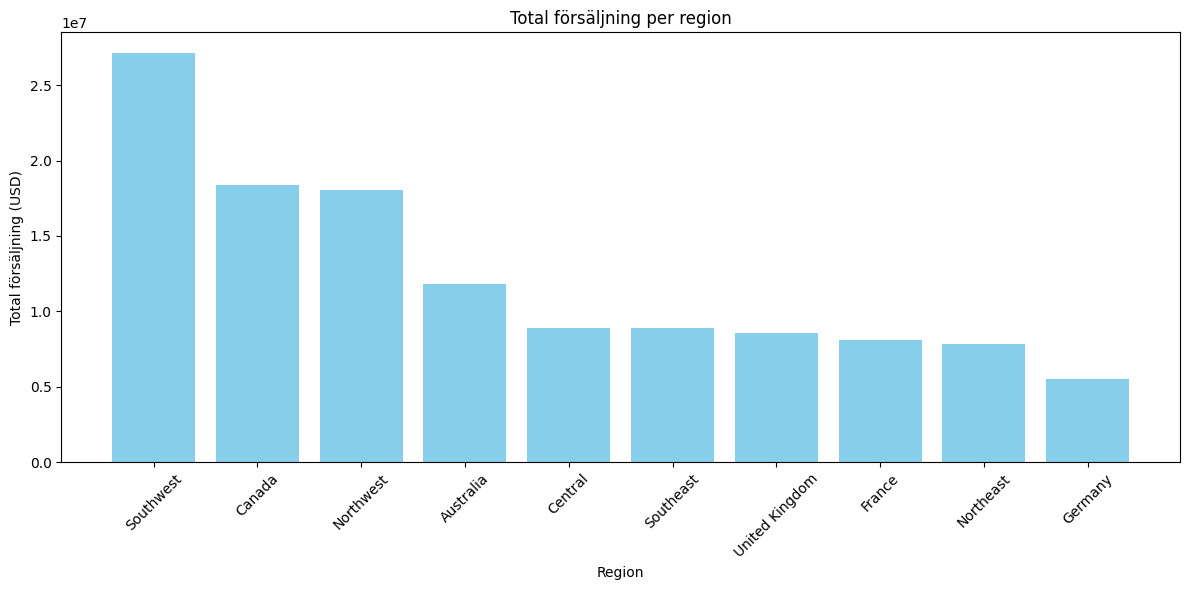

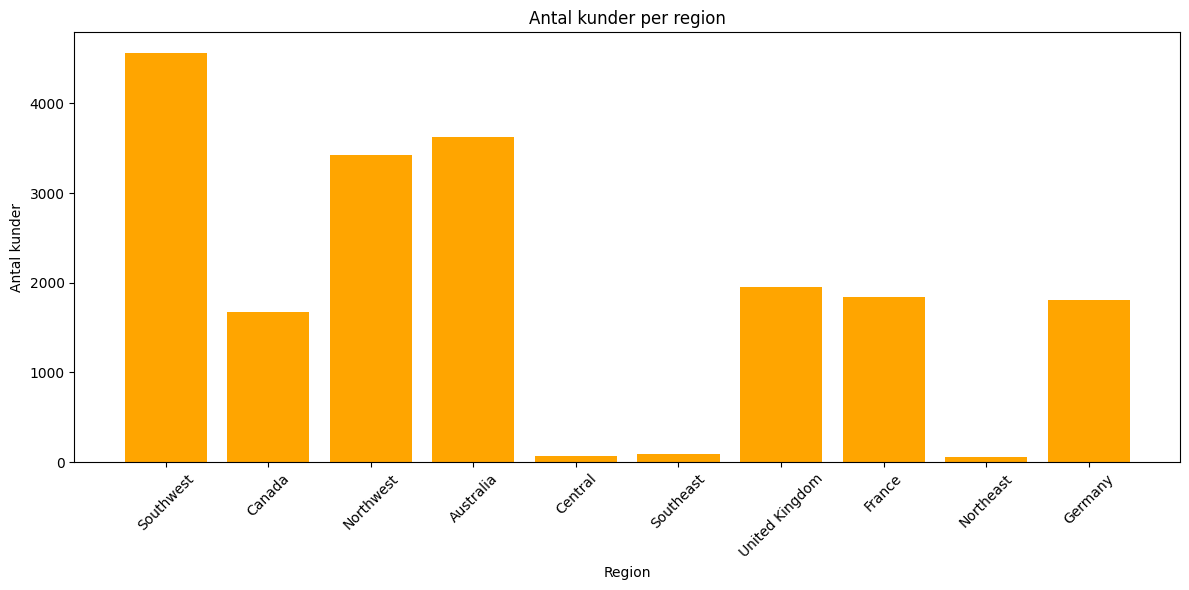

In [5]:
# --- Visualisering 6: Försäljning och antal kunder per region ---

# 1. Hämta data
df_vis6 = query_df("""
SELECT
    st.Name AS Region,
    SUM(soh.TotalDue) AS TotalSales,
    COUNT(DISTINCT c.CustomerID) AS UniqueCustomers
FROM Sales.SalesTerritory st
INNER JOIN Sales.SalesOrderHeader soh
    ON st.TerritoryID = soh.TerritoryID
INNER JOIN Sales.Customer c
    ON soh.CustomerID = c.CustomerID
GROUP BY st.Name
ORDER BY TotalSales DESC;
""")

# 2. Import
import matplotlib.pyplot as plt

# 3. Diagram 1 – Total försäljning per region
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(df_vis6['Region'], df_vis6['TotalSales'], color='skyblue')
ax.set_xlabel("Region")
ax.set_ylabel("Total försäljning (USD)")
ax.set_title("Total försäljning per region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Diagram 2 – Antal kunder per region
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(df_vis6['Region'], df_vis6['UniqueCustomers'], color='orange')
ax.set_xlabel("Region")
ax.set_ylabel("Antal kunder")
ax.set_title("Antal kunder per region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Insikter – Försäljning och antal kunder per region

Southwest är den starkaste regionen med både högst försäljning och flest kunder.  
Det visar att regionen drivs av både hög kundvolym och högt ordervärde.

Canada och Northwest ligger högt i försäljning men har färre kunder än Southwest.  
Det innebär att kunderna i dessa regioner gör större köp per person, vilket driver upp försäljningen trots en mindre kundbas.

Australia har många kunder men lägre försäljning, vilket tyder på lägre ordervärden per kund.  
Germany är den svagaste regionen med både låg försäljning och få kunder.

Analysen visar att vissa regioner växer tack vare många kunder (t.ex. Southwest), medan andra växer tack vare högt ordervärde per kund (t.ex. Canada och Northwest).  
Detta ger företaget två möjliga strategier: öka kundbasen i svaga regioner eller öka ordervärdet i regioner där kundantalet redan är högt.

## Visualisering 7 – Genomsnittligt ordervärde per region och kundtyp
Visualisering 7: Genomsnittligt ordervärde per region och kundtyp
Vilka regioner har högst genomsnittligt ordervärde, och skiljer det sig mellan företagskunder och privatkunder?

Tabeller som används:

- Sales.SalesTerritory

- Sales.SalesOrderHeader

- Sales.Customer

- Sales.Store

Plan:

- Identifiera kundtyp:

    - StoreID ≠ NULL → företagskund (Store)

    - StoreID = NULL → privatkund (Individual)

- Räkna total försäljning per region och kundtyp

- Räkna antal ordrar per region och kundtyp

- Beräkna genomsnittligt ordervärde (TotalSales / OrderCount)

- Sortera regioner från högst till lägst genomsnitt

- Skapa grupperat stapeldiagram

- Analysera resultatet

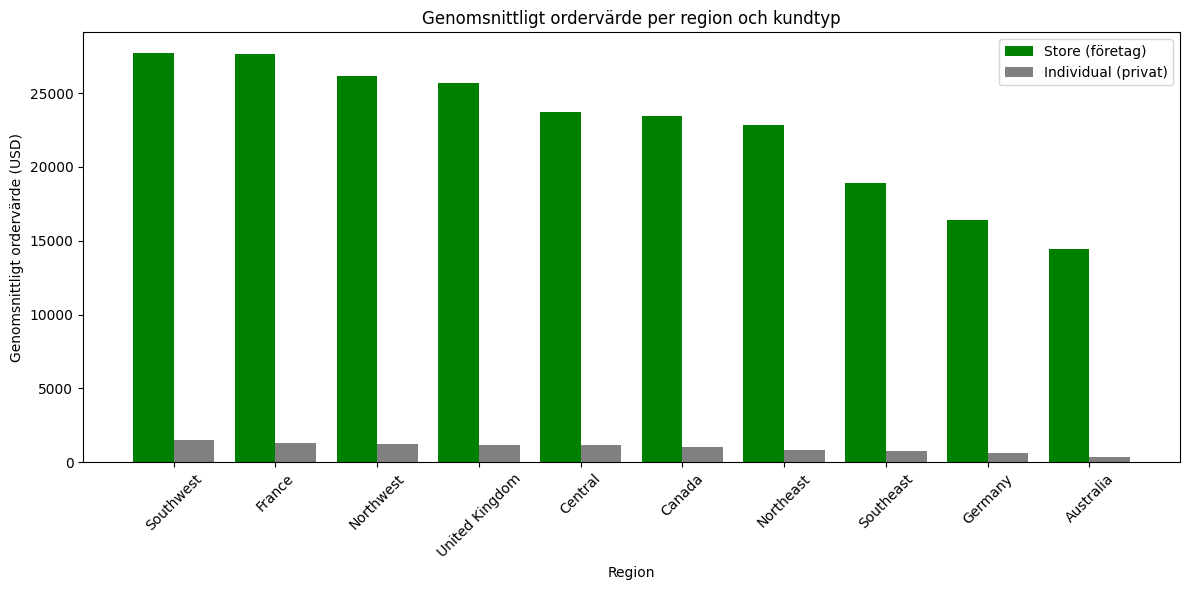

In [20]:
# SQL-query för visualisering 7
query_vis7 = """
SELECT
    st.Name AS Region,
    CASE 
        WHEN c.StoreID IS NULL THEN 'Individual'
        ELSE 'Store'
    END AS CustomerType,
    SUM(soh.TotalDue) AS TotalSales,
    COUNT(soh.SalesOrderID) AS OrderCount,
    SUM(soh.TotalDue) / COUNT(soh.SalesOrderID) AS AvgOrderValue
FROM Sales.SalesTerritory st
INNER JOIN Sales.SalesOrderHeader soh
    ON st.TerritoryID = soh.TerritoryID
INNER JOIN Sales.Customer c
    ON soh.CustomerID = c.CustomerID
GROUP BY st.Name,
         CASE WHEN c.StoreID IS NULL THEN 'Individual' ELSE 'Store' END
ORDER BY AvgOrderValue DESC;
"""

df_vis7 = query_df(query_vis7)

# Visualisering
fig, ax = plt.subplots(figsize=(12, 6))

regions = df_vis7['Region'].unique()
x = range(len(regions))

store_values = df_vis7[df_vis7['CustomerType'] == 'Store']['AvgOrderValue']
ind_values = df_vis7[df_vis7['CustomerType'] == 'Individual']['AvgOrderValue']

bar_width = 0.4

ax.bar([i - bar_width/2 for i in x], store_values, 
       width=bar_width, label='Store (företag)', color='green')
ax.bar([i + bar_width/2 for i in x], ind_values, 
       width=bar_width, label='Individual (privat)', color='gray')

ax.set_xticks(x)
ax.set_xticklabels(regions, rotation=45)

ax.set_xlabel("Region")
ax.set_ylabel("Genomsnittligt ordervärde (USD)")
ax.set_title("Genomsnittligt ordervärde per region och kundtyp")
ax.legend()

plt.tight_layout()
plt.show()


### Insikter – Genomsnittligt ordervärde per region och kundtyp

Företagskunder (Store) har betydligt högre genomsnittligt ordervärde än privatkunder (Individual) i samtliga regioner.  
Skillnaden är tydlig: Store ligger ofta 2–3 gånger högre än Individual.

Southwest har det högsta ordervärdet bland företagskunder, följt av France och Northwest.  
Det visar att företagskunder i dessa regioner gör stora inköp per order.

Privatkunder har generellt låga ordervärden, vilket är förväntat.  
Men regioner som United Kingdom och Central sticker ut med något högre värden även bland privatkunder.

Australia har lägst ordervärde för båda kundtyper, vilket gör den till den svagaste marknaden.

Analysen visar att företaget tjänar mest per order i regioner med starka företagskunder – särskilt Southwest och France.  
Dessa bör prioriteras i försäljning och marknadsföring.  
Regioner med låga ordervärden, som Australia, kan ha potential att växa genom kampanjer, merförsäljning eller riktade insatser mot privatkunder.



## Djupanalys ALTERNATIV A : Regional försäljningsoptimering

I denna djupanalys fokuserar vi på hur olika regioner presterar.
Vi undersöker:
- Vilken region presterar bäst och sämst
- Vilka produktkategorier som säljer bäst i olika regioner
- Om det finns säsongsmönster per region
- Vad företaget kan göra för att förbättra försäljningen


## Visualisering 1 : Total försäljning och genomsnittligt ordervärde per region
**Affärsfråga:** Vilken region presterar bäst och sämst, och hur stort är genomsnittligt ordervärde per region?

**Tabeller som används:**
- Sales.SalesTerritory
- Sales.SalesOrderHeader

**Plan:**
- Hämta total försäljning per region
- Räkna antal ordrar per region
- Beräkna genomsnittligt ordervärde (TotalSales / OrderCount)
- Sortera regioner från högst till lägst total försäljning
- Skapa ett kombinerat stapel- och linjediagram med två y-axlar (total försäljning + genomsnittligt ordervärde)
- Analysera vilka regioner som presterar bäst och sämst



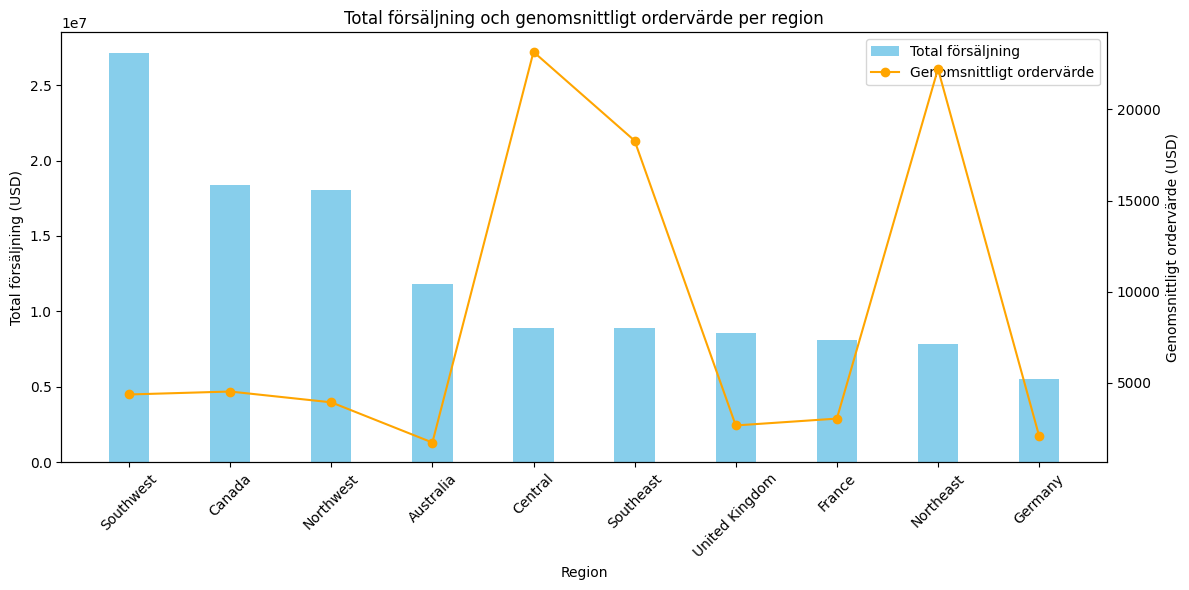

In [21]:
# SQL-query VG Visualisering 1
query_vg1 = """
SELECT
    st.Name AS Region,
    SUM(soh.TotalDue) AS TotalSales,
    COUNT(soh.SalesOrderID) AS OrderCount,
    SUM(soh.TotalDue) / COUNT(soh.SalesOrderID) AS AvgOrderValue
FROM Sales.SalesTerritory st
INNER JOIN Sales.SalesOrderHeader soh
    ON st.TerritoryID = soh.TerritoryID
GROUP BY st.Name
ORDER BY TotalSales DESC;
"""

df_vg1 = query_df(query_vg1)

# Visualisering
fig, ax1 = plt.subplots(figsize=(12, 6))

x = range(len(df_vg1))
bar_width = 0.4

# Staplar för total försäljning
ax1.bar(x, df_vg1['TotalSales'], width=bar_width, color='skyblue', label='Total försäljning')
ax1.set_xlabel("Region")
ax1.set_ylabel("Total försäljning (USD)")
ax1.set_xticks(x)
ax1.set_xticklabels(df_vg1['Region'], rotation=45)

# Linje för genomsnittligt ordervärde (sekundär axel)
ax2 = ax1.twinx()
ax2.plot(x, df_vg1['AvgOrderValue'], color='orange', marker='o', label='Genomsnittligt ordervärde')
ax2.set_ylabel("Genomsnittligt ordervärde (USD)")

# Legender
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

ax1.set_title("Total försäljning och genomsnittligt ordervärde per region")

plt.tight_layout()
plt.show()


### Insikter – Total försäljning och genomsnittligt ordervärde per region

Southwest är den starkaste regionen med klart högst total försäljning och ett högt genomsnittligt ordervärde.  
Canada och Northwest ligger också högt i försäljning, men något lägre än Southwest.

Germany är den svagaste regionen med både låg total försäljning och lägre genomsnittligt ordervärde.  
Även regioner som Northeast och France ligger betydligt lägre än toppregionerna.

Vi ser också att vissa regioner kombinerar hög försäljning med relativt högt ordervärde, medan andra har måttlig försäljning och lägre snitt per order.  
Det pekar på att skillnaderna mellan regionerna beror både på hur många ordrar som läggs och hur stora de är.

Analysen visar var företaget genererar mest intäkter totalt (t.ex. Southwest), och vilka regioner som har störst förbättringspotential (t.ex. Germany).



## Visualisering 2: Produktkategorier per region
**Affärsfråga:** Vilka produktkategorier säljer bäst i olika regioner?

**Tabeller som används:**
- Sales.SalesTerritory
- Sales.SalesOrderHeader
- Sales.SalesOrderDetail
- Production.Product
- Production.ProductSubcategory
- Production.ProductCategory

**Plan:**
- JOIN territorier, ordrar, orderrader och produkter
- Beräkna total försäljning per region och produktkategori
- Skapa en pivot-tabell i pandas (Region × Kategori)
- Visualisera som heatmap
- Analysera vilka kategorier som dominerar i olika regioner



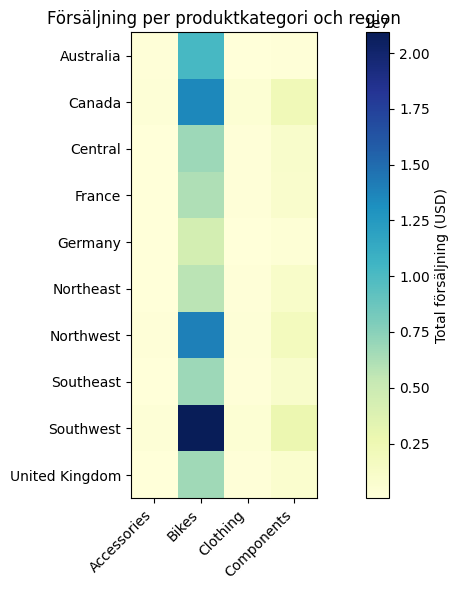

In [22]:
# SQL-query VG Visualisering 2
query_vg2 = """
SELECT
    st.Name AS Region,
    pc.Name AS CategoryName,
    SUM(sod.OrderQty * sod.UnitPrice) AS TotalSales
FROM Sales.SalesTerritory st
INNER JOIN Sales.SalesOrderHeader soh
    ON st.TerritoryID = soh.TerritoryID
INNER JOIN Sales.SalesOrderDetail sod
    ON soh.SalesOrderID = sod.SalesOrderID
INNER JOIN Production.Product p
    ON sod.ProductID = p.ProductID
INNER JOIN Production.ProductSubcategory psc
    ON p.ProductSubcategoryID = psc.ProductSubcategoryID
INNER JOIN Production.ProductCategory pc
    ON psc.ProductCategoryID = pc.ProductCategoryID
GROUP BY st.Name, pc.Name;
"""

df_vg2 = query_df(query_vg2)

# Pivot-tabell: Region x Kategori
pivot_vg2 = df_vg2.pivot(index='Region', columns='CategoryName', values='TotalSales')

# Visualisering: heatmap
fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.imshow(pivot_vg2, cmap='YlGnBu')

ax.set_xticks(range(len(pivot_vg2.columns)))
ax.set_xticklabels(pivot_vg2.columns, rotation=45, ha='right')
ax.set_yticks(range(len(pivot_vg2.index)))
ax.set_yticklabels(pivot_vg2.index)

ax.set_title("Försäljning per produktkategori och region")

fig.colorbar(cax, label='Total försäljning (USD)')

plt.tight_layout()
plt.show()


### Insikter – Produktkategorier per region

Heatmapen visar tydligt att Bikes är den dominerande produktkategorin i flera regioner, särskilt i Southwest där försäljningen är som högst.  
Även i regioner som Canada och Northwest står Bikes för en stor del av försäljningen.

Accessories, Clothing och Components är viktigare i vissa regioner än i andra, men når sällan upp till samma nivå som Bikes.  
Det innebär att produktmixen och vad som driver försäljning skiljer sig tydligt mellan regionerna.

Regioner där en enskild kategori, som Bikes, dominerar kan vara mer känsliga för förändringar i efterfrågan på just den kategorin.  
Regioner med en mer jämn fördelning mellan kategorier är mer diversifierade och mindre beroende av en enda produktgrupp.

Detta hjälper företaget att förstå vilka produktkategorier som driver försäljningen i olika delar av världen och var det kan vara värt att bredda eller fördjupa sortimentet.



## Visualisering 3: Säsongsmönster per region
**Affärsfråga:** Finns det säsongsmönster i försäljningen per region?

**Tabeller som används:**
- Sales.SalesTerritory
- Sales.SalesOrderHeader

**Plan:**
- Beräkna total försäljning per region och månad
- Skapa en tidsserie per region
- Visualisera några utvalda regioner i ett linjediagram
- Jämföra säsongsmönster mellan regioner


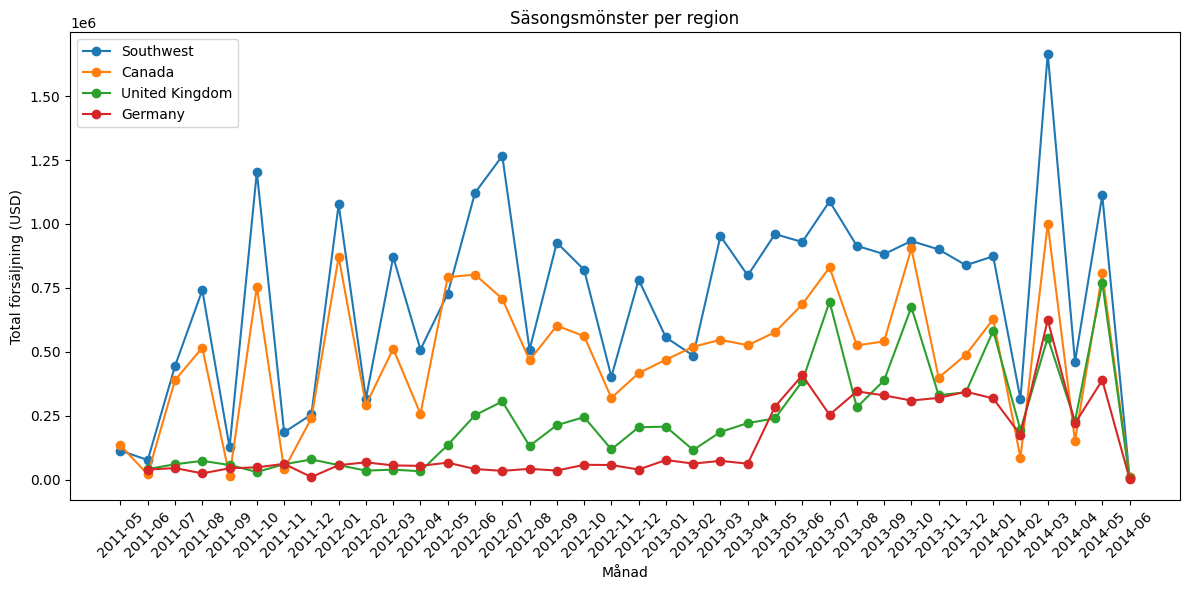

In [23]:
# SQL-query VG Visualisering 3
query_vg3 = """
SELECT
    st.Name AS Region,
    YEAR(soh.OrderDate) AS Year,
    MONTH(soh.OrderDate) AS Month,
    SUM(soh.TotalDue) AS TotalSales
FROM Sales.SalesTerritory st
INNER JOIN Sales.SalesOrderHeader soh
    ON st.TerritoryID = soh.TerritoryID
GROUP BY st.Name, YEAR(soh.OrderDate), MONTH(soh.OrderDate)
ORDER BY st.Name, Year, Month;
"""

df_vg3 = query_df(query_vg3)

# Skapa YearMonth-kolumn
df_vg3['YearMonth'] = df_vg3['Year'].astype(str) + "-" + df_vg3['Month'].astype(str).str.zfill(2)

# Välj några regioner att visualisera (t.ex. 3–4)
selected_regions = ['Southwest', 'Canada', 'United Kingdom', 'Germany']
df_vg3_sel = df_vg3[df_vg3['Region'].isin(selected_regions)]

# Visualisering
fig, ax = plt.subplots(figsize=(12, 6))

for region in selected_regions:
    data_region = df_vg3_sel[df_vg3_sel['Region'] == region]
    ax.plot(data_region['YearMonth'], data_region['TotalSales'], marker='o', label=region)

ax.set_xlabel("Månad")
ax.set_ylabel("Total försäljning (USD)")
ax.set_title("Säsongsmönster per region")
plt.xticks(rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


### Insikter – Säsongsmönster per region

Southwest har tydliga säsongstoppar med kraftiga uppgångar vissa perioder, vilket gör regionen mer volatil men också med hög potential under toppmånaderna.  
Canada och United Kingdom har också variation över tiden, men med mer jämna rörelser än Southwest.

Germany har lägst och mest stabil försäljning över hela perioden, med små variationer mellan månaderna.  
Det tyder på en svag men relativt förutsägbar marknad.

Analysen visar att säsongseffekterna skiljer sig mellan regioner.  
Företaget kan använda detta genom att anpassa kampanjer, lager och resurser efter vilka månader som är starkast i varje region – till exempel fokusera extra på Southwest under toppperioder och arbeta långsiktigt med att lyfta Germany.


## Reflektion (Regional försäljningsoptimering)

Jag valde denna djupanalys eftersom jag redan hade visualiseringar kopplade till regioner och ville fördjupa förståelsen av hur de presterar.  
Målet var att se inte bara total försäljning, utan även produktmix och säsongsmönster per region.

Jag valde att göra merparten av aggregeringen i SQL eftersom databasen är optimerad för sådana beräkningar.  
Det blir snabbare att gruppera och summera data i SQL, och sedan använda pandas för pivot-tabeller och visualisering.  
SQL passar särskilt bra för JOINs mellan många tabeller, medan pandas är starkt för att vrida och vända på resultatet i olika dimensioner.

Jag valde stapeldiagram, kombinerade stapel- och linjediagram samt heatmap eftersom de tydligt visar skillnader mellan regioner.  
Heatmapen gjorde det enkelt att se vilka produktkategorier som är starka i olika regioner, och linjediagrammet för säsongsmönster gjorde det lätt att följa utvecklingen över tid.

Pivot-tabellen hjälpte mig att se mönster i data från flera vinklar, speciellt kopplingen mellan region och produktkategori.  
Det gav en mer detaljerad bild än bara en enkel gruppning.

Utmaningar jag stötte på var bland annat att bygga rätt JOINs mellan flera tabeller och att hitta rätt nivå på aggregeringen.  
Jag löste detta genom att börja med enklare queries, testa delresultat och sedan bygga vidare steg för steg.  
Jag fick också justera visualiseringarna för att de skulle bli tydliga och läsbara.

De konkreta rekommendationerna från djupanalysen är:
- Fokusera på regioner som har hög total försäljning och högt genomsnittligt ordervärde.
- Identifiera svagare regioner med låg försäljning och analysera om problemet är få kunder eller låga ordervärden.
- Anpassa produktmixen per region utifrån vilka kategorier som säljer bäst där.
- Planera marknadsföring och kampanjer utifrån säsongsmönster i respektive region.


## Sammanfattning

### Huvudsakliga fynd

Analysen visar att försäljningen varierar tydligt mellan regionerna, både i total nivå och i genomsnittligt ordervärde.  
Southwest är den starkaste regionen, medan regioner som Germany ligger klart lägre.

Vi ser också att produktkategorier presterar olika bra i olika regioner.  
Bikes dominerar ofta, särskilt i starka regioner som Southwest, medan andra kategorier kan vara viktigare lokalt.

Säsongsmönstren skiljer sig mellan regionerna.  
Vissa, som Southwest, har tydliga toppar, medan andra, som Germany, har låg men relativt stabil försäljning över tid.

### Rekommendationer – Vad kan företaget göra?

- **Prioritera starka regioner:** Fortsätt att satsa på regioner med hög försäljning och högt ordervärde, som Southwest, för att maximera intäkter.  
- **Analysera och utveckla svagare regioner:** För regioner som Germany bör företaget undersöka om problemet är få kunder, låga ordervärden eller svag produktmix, och testa åtgärder som kampanjer eller lokalt anpassad marknadsföring.  
- **Optimera produktmix per region:** Använd insikterna från produktkategorier per region för att optimera lager och sortiment så att rätt produkter finns på rätt marknad.  
- **Planera efter säsong:** Anpassa resurser, lager och kampanjer efter säsongsmönstren i varje region, till exempel genom att förstärka närvaro under toppmånader i starka regioner.

Denna djupanalys ger en tydligare bild av var företaget tjänar mest pengar idag och var det finns störst potential att växa framöver.
